In [1]:
import os
os.chdir('../../') #if we are in notebooks folder

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import cos_normal_noise


from models.mlp import mlp
from utilities.fits import fit

## Load Dataset

In [3]:
dataset, targets = cos_normal_noise.load()
X, x_test1, x_test2 = dataset
y, y_test1, y_test2 = targets

# MC Dropout

In [4]:
model = mlp(features=[32, 64, 32, 1], activations=[nn.relu, nn.relu, nn.relu], 
            dropout_rate=[0.03]*3)

In [9]:
# initialize model
params = model.init(jax.random.PRNGKey(0), X, deterministic = True)

In [10]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                            mlp Summary                            
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path           ┃ outputs               ┃ params                 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs         │ - float32[100,1]      │                        │
│                │ - deterministic: True │                        │
├────────────────┼───────────────────────┼────────────────────────┤
│ 0_Dense        │ float32[100,32]       │ bias: float32[32]      │
│                │                       │ kernel: float32[1,32]  │
│                │                       │                        │
│                │                       │ 64 (256 B)             │
├────────────────┼───────────────────────┼────────────────────────┤
│ 0_Dropout_0.03 │ float32[100,32]       │                        │
├────────────────┼───────────────────────┼────────────────────────┤
│ 1_Dense        │ float32[100,64]       │ bias: float32[64]      │
│                │                       │ kernel: float32[32,64] │
│                │                       │                        │
│                │                       │ 2,112 (8.4 KB)         │
├────────────────┼───────────────────────┼────────────────────────┤
│ 1_Dropout_0.03 │ float32[100,64]       │                        │
├────────────────┼───────────────────────┼────────────────────────┤
│ 2_Dense        │ float32[100,32]       │ bias: float32[32]      │
│                │                       │ kernel: float32[64,32] │
│                │                       │                        │
│                │                       │ 2,080 (8.3 KB)         │
├────────────────┼───────────────────────┼────────────────────────┤
│ 2_Dropout_0.03 │ float32[100,32]       │                        │
├────────────────┼───────────────────────┼────────────────────────┤
│ 3_Dense        │ float32[100,1]        │ bias: float32[1]       │
│                │                       │ kernel: float32[32,1]  │
│                │                       │                        │
│                │                       │ 33 (132 B)             │
├────────────────┼───────────────────────┼────────────────────────┤
│ mlp            │ float32[100,1]        │                        │
├────────────────┼───────────────────────┼────────────────────────┤
│                │                 Total │ 4,289 (17.2 KB)        │
└────────────────┴───────────────────────┴────────────────────────┘
                                                                   
                 Total Parameters: 4,289 (17.2 KB)                 

'\n\n'

In [11]:
auxs = {
    "X" : X,
    "y" : y,
    "deterministic": False,
}
params, losses =  fit(model, params, auxs, learning_rate=0.01, epochs=1000, verbose=True)

Loss step 0:  1.7164602
Loss step 100:  0.034710504
Loss step 200:  0.029444756
Loss step 300:  0.025641512
Loss step 400:  0.02668335
Loss step 500:  0.021966757
Loss step 600:  0.01703726
Loss step 700:  0.01682363
Loss step 800:  0.012155244
Loss step 900:  0.008724272


Text(0, 0.5, 'y')

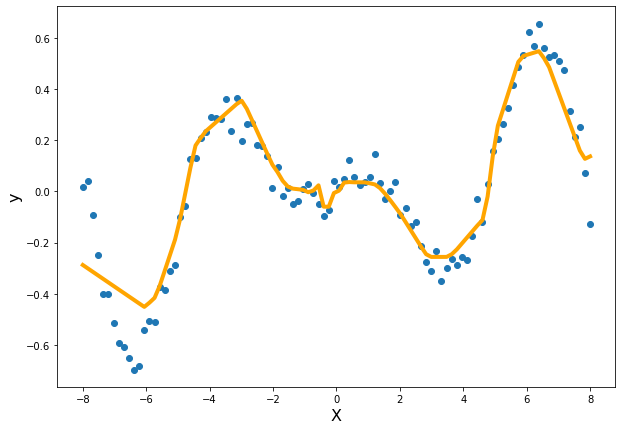

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(X,y)
# plt.scatter(x_test1,y_test1)
# plt.scatter(x_test2,y_test2)
plt.plot(X, model.apply(params, X, deterministic=True), "orange", linewidth=4)
# plt.plot(x_test1, model.apply(params,x_test1, deterministic=True),"red", linewidth = 5)
# plt.plot(x_test2, model.apply(params,x_test2, deterministic=True), "red", linewidth = 5)
# sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)

In [9]:
x = jnp.linspace(-10, 10, 200).reshape(-1,1)
n_stacks = 100
y_stacks = []
for i in range(n_stacks):
    y_stacks.append(model.apply(params, x, deterministic=False, rate = 0.1, rngs={"dropout": jax.random.PRNGKey(i)}))

In [10]:
y_stacks = jnp.array(y_stacks)

(-10.0, 10.0)

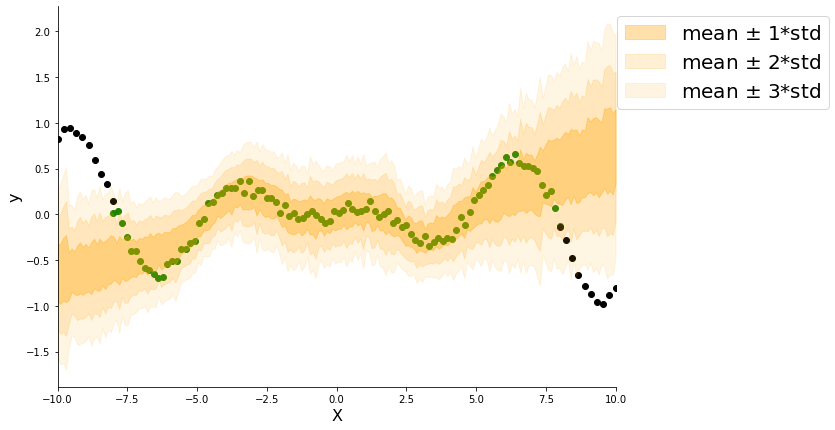

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(X, y, c="g")
plt.scatter(x_test1,y_test1, c="k")
plt.scatter(x_test2,y_test2, c="k")
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()
for i in range(1,4):
    plt.fill_between(x.squeeze(), mean - i*std, mean + i*std, color="orange", alpha = 1/(i*3), label = f"mean $\pm$ {i}*std")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-10,10)
# plt.savefig("mc_dropout_.pdf",bbox_inches="tight")